<h1 align="center"> Martin's AI Chess Interpreter <h1>
<h2 align="center"> Computer Vision Final Assignment </h2>
<h4 align="center"> Martin Sejas - AIS 2023 </h4>

## Sources:
- [Kaggle Dataset Link](https://www.kaggle.com/datasets/koryakinp/chess-positions)
- [Kaggle Example Notebook](https://www.kaggle.com/code/koryakinp/chess-fen-generator/notebook)
- [Kaggle Improved Notebook](https://www.kaggle.com/code/meditech101/chess-fen-generator-improved)
- ChatGPT Explanation of the FEN system.
- Hands-On Machine Learning with Scikit-Learn, Keras  & Tensorflow - Aurelien Geron (BOOK)

My dataset is a set of images of a chessboard, and I need to predict the name which are also the chess positions. My first step is to load the paths of the images into a dataframe or list so I can process them.


## Step 0: Importing relevant libraries and making dataset

Here I have downloaded a huge amount of images, around 4.2k. Considering that if I make a dataset of the image themselves in the future, all of them will be stored in RAM. Considering we have thousands of pictures, it is safe to say my computer will crash. 

Hence to mitigate this problem I have investigated quite a lot the use of *generators* which works a lot like a for loop where you can access the variables at each loop, very interesting. (Took me a lot of time and troubleshooting)

All of the images are 400x400.

In [1]:
import os 
import pandas as pd

DIRECTORY_PATH = "C:/Users/Martin/Desktop/Class Exercises/AIS S3/ComputerVision/chess-positions/data/"


#this will be my X in my dataset
image_paths = []

#this will be my Y in my dataset
labels = []

for index,image_path in enumerate(os.listdir(DIRECTORY_PATH)):
   
   # saving the image path as my feature 
    image_paths.append(DIRECTORY_PATH+image_path)
    
     #slicing the array to remove .jpeg and adding it to my Y
    labels.append(image_path[:-5])
    

   

Making a dataset out of the retrieved information.

In [2]:
df = pd.DataFrame()

df['paths'] = image_paths
df['labels'] = labels
df.head()

,paths,labels
0,C:/Users/Martin/Desktop/Class Exercises/AIS S3...,1b1B1Qr1-7p-6r1-2P5-4Rk2-1K6-4B3-8
1,C:/Users/Martin/Desktop/Class Exercises/AIS S3...,1B1B2K1-1B6-5N2-6k1-8-8-8-4nq2
2,C:/Users/Martin/Desktop/Class Exercises/AIS S3...,1b1b2K1-1r6-2P4p-1b1p4-4N1k1-3B2Q1-2q5-2N2q2
3,C:/Users/Martin/Desktop/Class Exercises/AIS S3...,1b1b2k1-K2B1q2-R3B2p-3b1NR1-5p2-3N4-8-5N2
4,C:/Users/Martin/Desktop/Class Exercises/AIS S3...,1B1B3R-8-1b2k3-8-2n5-1rK5-b7-8


# Step 1: Splitting and Studying the Data

Making a 80:20 split between training and test.

In [3]:
from sklearn.model_selection import train_test_split

X = df['paths']
Y = df['labels']

#Making
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

X_train.shape, X_test.shape

((3408,), (853,))

Now we will check the dimensions of our images, if they are different sizes we need to resize them to the same size. 

If they are all the same size, but too big we need to make sure we reduce them to a processable size.

To do so I will make a dataset of all the widths and heights of the images.

In [4]:
from PIL import Image
import numpy as np

widths = [None]*len(X)
heights = [None]*len(X)

for idx,image_path in enumerate(X):
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            widths[idx] = width
            heights[idx]= height
    except IOError:
        print(f"Unable to load image {image_path}")
        
        
df['widths'] = widths
df['heights'] = heights

df.describe()

,widths,heights
count,4261.0,4261.0
mean,400.0,400.0
std,0.0,0.0
min,400.0,400.0
25%,400.0,400.0
50%,400.0,400.0
75%,400.0,400.0
max,400.0,400.0


We can see here that all images are the same size, 400x400, this is still quite big, so we are going to resize them to 200x200.


With this I can already start considering a crucial step in this problem, how can I convert the label into something the machine can read (i.e. How can I convert a string to text to a number?)

This is an important problem to solve to train our neural network.

Let's load a sample image and it's label so we can see what we are dealing with.

In [5]:
sample_image = Image.open(X[0])

The FEN notation shown in the datasets has a simple format, it's a way of representing chess pieces in the board.

We start with the uppermost rank (8th), and will determine the chess pieces from left to right. 

We have the following pieces being represented by a letter:
(uppercase for white / lowercase for black)

- Pawn - (P/p)
- Knight - (N/n)
- Bishop - (B/b)
- Rook - (R/r)
- Queen - (Q/q)
- King - (K/k)

If there is an empty square, or a sequence of empty squares, these are represented by a number. 



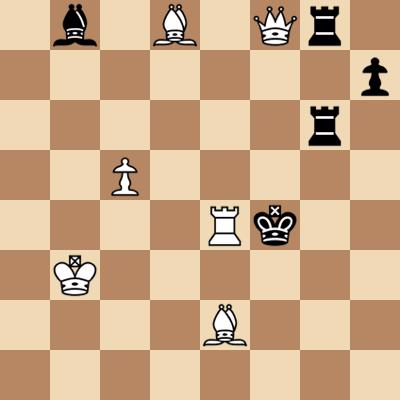

In [6]:
sample_image

Hence it is easy to determine with this system how it works.

If we consider the uppermost row, reading left to right we can see there is:
- 1 space (1)
- a black bishop (b)
- 1 space (1)
- a white bishop (B)
- 1 space (1)
- a white queen (Q)
- a black rook (r)
- 1 space (1)

From this we can just join together the sequence to describe the row:
- 1b1B1Qr1

We can just chain them together to describe row by row, by separating each row with a '-'. 

For example describing the 7th rank (second uppermost rank) is easy as there is a sequence of 7 empty squares, and in the end a black pawn.

Following the same system as above we simply write: 
- 7p

We can concatenate everything like so:

- 1b1B1Qr1-7p

And so on, until we describe the 8 ranks of the board.

For the 6th rank: 
- 6r1

5th: 
- 2P5 

etc...

The first few ranks should look like this:
- 1b1B1Qr1-7p-6r1-2P5

We can check by printing the label for the image above.



In [7]:
Y[0]

'1b1B1Qr1-7p-6r1-2P5-4Rk2-1K6-4B3-8'

We can see that we are correct. Hence now we have to think of how to represent the data so a machine can read it. 

Ideally I would like to just map each of the 6 white pieces, each of the 6 black pieces, plus an empty square as a class, 1-13, and see if it works. 
That way I will only need an 8x8 matrix as my final output. 

There is always a risk on using big numbers in Neural Networks, and it might not work. 

The example notebook above uses one hot encoding so it actually ends with a 64*13 matrix as the label. 

I'm not the biggest fan of it, so I will try my approach first, however if it doesn't work I will go back to the tried and tested notebook form.


*P.S. After completing the notebook I can say it doesn't matter much, on my research I discovered even if I keep class labels as integers, TensorFlow will eventually one-hot encode them (if I use sparse-categorical-crossentropy as a loss instead of the normal one), when compiling the model, my guess is that TF will do optimizations under the hood, and also save some memory when dealing with a big number of classes by not One-Hot Encoding the entire dataset, just the final output, but it will still output a one-hot encoded version, nevertheless it did make writing the encoding and decoding code easier*



# Step 2: Pre-Processing the Data

## Preprocessing the labels

I will be making a dictionary to map the pieces to a number.

In [8]:
#This dictionary is for encoding
piece_dictionary = {}

#my pieces are: pnbrqkPNBRQK
piece_dictionary["p"] = 1
piece_dictionary["n"] = 2
piece_dictionary["b"] = 3
piece_dictionary["r"] = 4
piece_dictionary["q"] = 5
piece_dictionary["k"] = 6
piece_dictionary["P"] = 7
piece_dictionary["N"] = 8
piece_dictionary["B"] = 9
piece_dictionary["R"] = 10
piece_dictionary["Q"] = 11
piece_dictionary["K"] = 12

#I am not including spaces, I will simply map them to 0

I will also need to reverse the operation so I will need a decoding dictionary, however we just have to swap the keys and the values of the dictionary we just made.

In [9]:
#This dictionary is for decoding
piece_reverse_dictionary = {
    0: '1',
    1: 'p',
    2: 'n',
    3: 'b',
    4: 'r',
    5: 'q',
    6: 'k',
    7: 'P',
    8: 'N',
    9: 'B',
    10: 'R',
    11: 'Q',
    12: 'K'
}
    

Now I just need to make a function for encoding the label, and one to decode the label.

In [10]:
import numpy as np


def encode_label(label: str):
    #Splitting the label row by row
    rows = label.split("-")
    
    # Making a list of lists for my final encoded label
    # PreAllocating for good practice
    board = [None] * 8
    
    for row_id, row in enumerate(rows):
        encoded_row = [0] * 8
        row_item = 0  # Initialize row_item outside the loop
            
        for square in row:
            #not get index out of range
            if(row_item > 7):
                break
            
            #If it's a piece, map it according to dictionary
            if square in piece_dictionary:
                encoded_row[row_item] = piece_dictionary[square]
                row_item += 1
            
            #If it's empty squares, adjust accordingly the insertion of the row 
            else:       
                empty_spaces = int(square)
                if empty_spaces == 1:
                    row_item+=1
                else:
                    row_item+= empty_spaces
                          
        board[row_id] = encoded_row
        
    #convert to flat numpy array (for processing)
    return (np.array(board).flatten())


Quite proud of this function, it took me a bit of time to get it working perfectly.

Let's test on the first label.

In [11]:
encoded_label = encode_label(Y[0])  
encoded_label.shape

(64,)

Now we must write a decoding function.

In [12]:
def decode_label(encoded_label: np.ndarray):
    encoded_label = encoded_label.reshape(8,8)
    
    label = '' #Final label
    
    for row in encoded_label:
        row_string = ''
        empty_count = 0
        for piece_id in row:
            if piece_id == 0:
                empty_count += 1
            else:
                if empty_count > 0:
                    row_string += str(empty_count)
                    empty_count = 0
                row_string += piece_reverse_dictionary[piece_id]
        if empty_count > 0:
            row_string += str(empty_count)
        label += row_string + '-'
    
    # Remove the trailing '-'
    label = label[:-1]
    return label

    

Testing the decoding.

In [13]:
decode_label(encoded_label), Y[0]

('1b1B1Qr1-7p-6r1-2P5-4Rk2-1K6-4B3-8', '1b1B1Qr1-7p-6r1-2P5-4Rk2-1K6-4B3-8')

We can try the same thing with the second:

In [14]:
assert Y[1] == decode_label(encode_label(Y[1]))

With this working we can proceed to pre-process the images and the chess pieces are now readable to the computer.

## Pre-processing images

We can also write a function to resize the image to 200x200 as defined before, as well as applied min max scaling by dividing all pixels by 255 to normalize the images.


*Here it was obvious to me it made sense to split the image in 64 pieces, one for each square, and just focus on the square. I ran into enormous problems because I was trying to use a batch of images, where each image was split in 64 pieces, I wsa getting 5D tensors like such (batch_size,64,25,25,3) which was really bugging a lot. For this part I did use a lot of sources to split evenly each square, especially the Kaggle Notebook linked to the dataset (Second source)*

*I overcame the problem by realizing that the image that got split in 64, is the batch itself, not the original image, I was processing a batch of 64 images at a time, so I had to process my original images, 1 by 1. Seems a bit obvious but it took me about 2 hours of debugging to reach this conclusion*

In [15]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from skimage.util.shape import view_as_blocks
from skimage import io, transform


def resize_image(image_path:str):
    downsample_size = 200
    square_size = 200//8
    img_read = io.imread(image_path)
    img_read = transform.resize(
      img_read, (downsample_size, downsample_size), mode='constant')
    tiles = view_as_blocks(img_read, block_shape=(square_size, square_size, 3))
    tiles = tiles.squeeze(axis=2)
    return tiles.reshape(64, square_size, square_size, 3)
    


resize_image(X_train.values[0]).shape

(64, 25, 25, 3)

Here comes the part where I did a lot of research. For some reason it took me a lot of research to get this working right, but I really wanted to learn how to process datasets that don't fit in your RAM as I think it is essential to any Data Scientist as good models require huge amounts of data. 

I tried many different combinations, pre-building tensors, making TensorFlow datasets etc, etc. 

In the end after trial and error I understood how generator functions in python work, they are basically loops where you can 'yield' or spit out values at each iteration.

Hence I wrote my own generator function (which TensorFlow accepts in their model.fit() function), which will get the path of an image, open it, resize it, split it in 64 and give it back. 

As well as with the label, where it will encode it, and give it back.

With this logic we can encapsulate everything in a generator function that will train my model in batches (I can't fit all images in RAM).

In [16]:

#Setting default batch size to 32, but can change if needed
def dataset_generator(df:pd.DataFrame):
    samples_size = df.shape[0]
    # These steps per epoch represents the number of loops to be made, in my case it I'm spitting out one image at a time
    # And I have 3408 images
    steps_per_epoch = -(-samples_size // 1)  # These steps per epoch represents the number of loops to be made
    

    for  i in range(steps_per_epoch):
        batch_paths = df['paths'].values[i]
        batch_labels = df['labels'].values[i]
        
        #pre-process the images
        batch_images = resize_image(batch_paths) #shape (64,25,25,3)
        
        #process the label
        batch_encoded_labels = encode_label(batch_labels)#shape (64,)
        
        #spit them out
        yield batch_images, batch_encoded_labels
    


Testing generator

In [30]:
df_small = df.sample(5)

for batch_images, encoded_labels in dataset_generator(df_small):
    print(batch_images.shape)
    print(encoded_labels.shape)
    

(64, 25, 25, 3)
(64,)
(64, 25, 25, 3)
(64,)
(64, 25, 25, 3)
(64,)
(64, 25, 25, 3)
(64,)
(64, 25, 25, 3)
(64,)


Creating my training dataset, by merging everything together.

In [18]:
df_train = pd.DataFrame()

df_train["paths"] = X_train
df_train["labels"] = Y_train

df_train.shape

# Step 3: Building a Convolutional Neural Network

Here for this part I read all the chapters in my book on CNNs as well as taking in account the class material. 

I've read that relu activation functions are better initialized with He Initialization which is why I have specified. 

Additionally I adopt the standard CNN architecture of one Convolution layer, then doubling the filters and repeat. 

I started with 64 as I have 64 squares, and kept using numbers multiple of 64 due to that reason. 

Just the first kernel is big, I chose 8, again for obvious reasons, and I also implemented my own default Convolutional leyer with my own parameters.

In the end as I said, I still get a sort of one hot encoded output, but the sparse-categorical cross entropy loss works just fine. 

I used SGD with nesterov momentum for my Optimizer, because I was only going through every sample once. 

I also added a dropout layer in the end for regularization.

In [20]:
from keras.layers import Conv2D
from functools import partial

#From the book, it shows you can customize Keras defaults
DefaultConv2D = partial(Conv2D, kernel_size=3, padding="same", activation="leaky_relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    Conv2D(filters=64, activation='leaky_relu',kernel_size=8, padding="same", kernel_initializer="he_normal", input_shape=[25,25,3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation="leaky_relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(units=128, activation="leaky_relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(units=64, activation="leaky_relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=13, activation="softmax"),    
   
   
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9,nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])



In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 64)        12352     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 256)         2

I will only train on 1 epoch because of the generator. Steps per epoch simply represent all of my training set.

In [22]:
history = model.fit(dataset_generator(df_train),epochs=1,steps_per_epoch=3408)

3408/3408 [==============================] - 786s 230ms/step - loss: 0.1533 - accuracy: 0.9584


# Step 4: Getting Predictions and Testing the Model

To predict my data I still need to pre-process the image, so I write a simple function to do that (another generator).

My model shows around 96% accuracy which makes me very happy. Which is why I will not be testing other configurations.

In [23]:
def predict_gen(Xtest):
    for index, image in enumerate(Xtest):
        yield resize_image(image)
   

Here I got all my predictions as a range of probabilities, I have to argmax each one to get the right class.

In [24]:
predictions = []

for img in predict_gen(X_test.values):
    predictions.append(decode_label(model.predict(img,verbose=False).argmax(axis=1)))

With all of the predictions, I visually check one.

In [25]:
predictions[0],Y_test.values[0]

('2Q1K3-8-8-2R2Rb1-3N1Pn1-5k1n-5B2-8', '2Q1K3-8-8-2R2Rb1-3N1Pn1-5k1n-5B2-8')

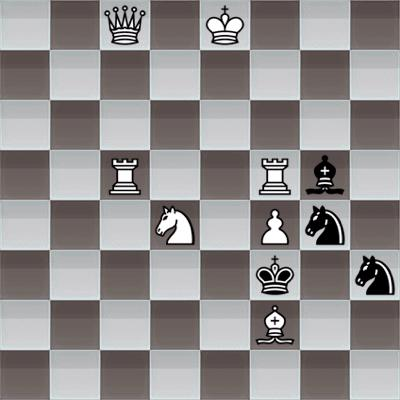

In [26]:
Image.open(X_test.values[0])

# Step 5: Getting Metrics on the Test Dataset

Very simple case of just seeing if the prediction is equal to the label.

In [27]:
total = Y_test.shape[0]

total
correct_labels = 0

for index,label in enumerate(Y_test.values):
    if predictions[index] == label:
        correct_labels+=1

print("Test Accuracy:",correct_labels/total)

Test Accuracy: 0.9742086752637749


# Step 6: Saving Model for Predictions

Dumping model for generalized predictions. Please find the Script in the repository :).

In [29]:
import joblib

joblib.dump(model,"../models/martin_chess.joblib")



['../models/martin_chess.joblib']